data from here

https://github.com/phelber/EuroSAT

In [1]:
# install these if using new compute

# pip install seaborn
# pip install scikit_learn
# pip install tensorflow-addons
#%pip install transformers
#%pip install tf-keras
#%pip install keras-cv
#%pip install tensorflow-hub

In [2]:
# data manipulation libraries
import pandas as pd
import numpy as np
import copy
import os

# imports visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

# trying to suppress warnings
tf.get_logger().setLevel('ERROR')

# Suppress annoying warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # supress tensorflow warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras.utils import image_dataset_from_directory
from keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model

# take this off if using GPU
# Ensure no GPUs are visible to TensorFlow
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU
# tf.config.experimental.set_visible_devices([], 'GPU')

# evaluation
from sklearn.metrics import confusion_matrix,  f1_score, accuracy_score

2025-03-21 09:43:55.445881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742550236.103438    3529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742550236.300704    3529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 09:43:58.190703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Getting all images into dataset to compare classes are evenly split over train/test/val

In [3]:
all_images = tf.keras.utils.image_dataset_from_directory(
    directory = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB',
    #validation_split=0.3,  # Reserve 30% of data for validation and test
    #subset='validation',
    color_mode='rgb',
    #seed=321,
    #shuffle=True,
    image_size=(256, 256),
    batch_size=32,
    )

Found 27000 files belonging to 10 classes.


I0000 00:00:1742550265.585976    3529 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14780 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


# This splits into train/test/val without data leakage

In [4]:
%%time
# function to import the data
# https://keras.io/examples/vision/image_classification_from_scratch/

def import_data(image_size, batch_size, colour, base_dir):
    # 70/30 split
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,  # 30% of data for validation and test
        subset='validation',
        color_mode=colour,
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    # further split the 30% reserved dataset into validation (15%) and test (15%)
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    
    # val set set half of 30%
    val_ds = full_val_test_ds.take(val_size)
    
    # test set is remaining half of 30%
    test_ds = full_val_test_ds.skip(val_size)
    
    # train set - 70%
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,
        subset='training',
        color_mode=colour,
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    return train_ds, val_ds, test_ds

base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (256, 256)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, colour, base_dir)

Found 27000 files belonging to 10 classes.
Using 8100 files for validation.
Found 27000 files belonging to 10 classes.
Using 18900 files for training.
CPU times: user 1.73 s, sys: 1.4 s, total: 3.14 s
Wall time: 2.6 s


In [5]:
# get class names for using later
class_names = train_ds.class_names

# EDA

In [6]:
# inspect new datasets

In [7]:
# getting counts of classes
def inspect_dataset(dataset, class_names):
    # initialise counters
    total_count = 0
    class_counts = {class_name: 0 for class_name in class_names}
    
    for images, labels in dataset:
        # count total images
        total_count += images.shape[0]
        
        # count classes
        for label in labels.numpy():
            class_counts[class_names[label]] += 1
    
    return total_count, class_counts

In [8]:
# create df's
def create_df(dict):    
    df = pd.DataFrame.from_dict(dict, orient="index")
    df = df.reset_index()
    df = df.rename(columns={"index": "Category", 0: "Count"})
    # calculate the percentage for each category
    total_count = df['Count'].sum()
    df['Percentage'] = round(((df['Count'] / total_count) * 100),2)

    return df

# Inspect the data

In [9]:
# warning at bottom might be because i'm not splitting the dataset into training and validation for the full set

all_total, all_per_class = inspect_dataset(all_images, class_names)
print(f"Full data set: {all_total} images")
print("Per class:", all_per_class)

train_total, train_per_class = inspect_dataset(train_ds, class_names)
print(f"Full data set: {train_total} images")
print("Per class:", train_per_class)

val_total, val_per_class = inspect_dataset(val_ds, class_names)
print(f"Full data set: {val_total} images")
print("Per class:", val_per_class)

test_total, test_per_class = inspect_dataset(test_ds, class_names)
print(f"Full data set: {test_total} images")
print("Per class:",test_per_class)

Full data set: 27000 images
Per class: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}
Full data set: 18900 images
Per class: {'AnnualCrop': 2070, 'Forest': 2126, 'HerbaceousVegetation': 2099, 'Highway': 1722, 'Industrial': 1758, 'Pasture': 1433, 'PermanentCrop': 1797, 'Residential': 2092, 'River': 1733, 'SeaLake': 2070}
Full data set: 4032 images
Per class: {'AnnualCrop': 438, 'Forest': 438, 'HerbaceousVegetation': 460, 'Highway': 375, 'Industrial': 375, 'Pasture': 291, 'PermanentCrop': 344, 'Residential': 438, 'River': 404, 'SeaLake': 469}


2025-03-21 09:45:50.219466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# class distribution and percentage per class

In [10]:
all_df = create_df(all_per_class)
train_df = create_df(train_per_class)
val_df = create_df(val_per_class)
test_df = create_df(test_per_class)

In [11]:
all_df

,Category,Count,Percentage
0,AnnualCrop,3000,11.11
1,Forest,3000,11.11
2,HerbaceousVegetation,3000,11.11
3,Highway,2500,9.26
4,Industrial,2500,9.26
5,Pasture,2000,7.41
6,PermanentCrop,2500,9.26
7,Residential,3000,11.11
8,River,2500,9.26
9,SeaLake,3000,11.11


In [12]:
train_df

,Category,Count,Percentage
0,AnnualCrop,2070,10.95
1,Forest,2126,11.25
2,HerbaceousVegetation,2099,11.11
3,Highway,1722,9.11
4,Industrial,1758,9.30
5,Pasture,1433,7.58
6,PermanentCrop,1797,9.51
7,Residential,2092,11.07
8,River,1733,9.17
9,SeaLake,2070,10.95


In [13]:
val_df

,Category,Count,Percentage
0,AnnualCrop,438,10.86
1,Forest,438,10.86
2,HerbaceousVegetation,460,11.41
3,Highway,375,9.30
4,Industrial,375,9.30
5,Pasture,291,7.22
6,PermanentCrop,344,8.53
7,Residential,438,10.86
8,River,404,10.02
9,SeaLake,469,11.63


In [14]:
test_df

,Category,Count,Percentage
0,AnnualCrop,485,11.92
1,Forest,432,10.62
2,HerbaceousVegetation,459,11.28
3,Highway,395,9.71
4,Industrial,364,8.95
5,Pasture,283,6.96
6,PermanentCrop,360,8.85
7,Residential,469,11.53
8,River,358,8.80
9,SeaLake,463,11.38


# Display histogram of class distribution for the whole dataset

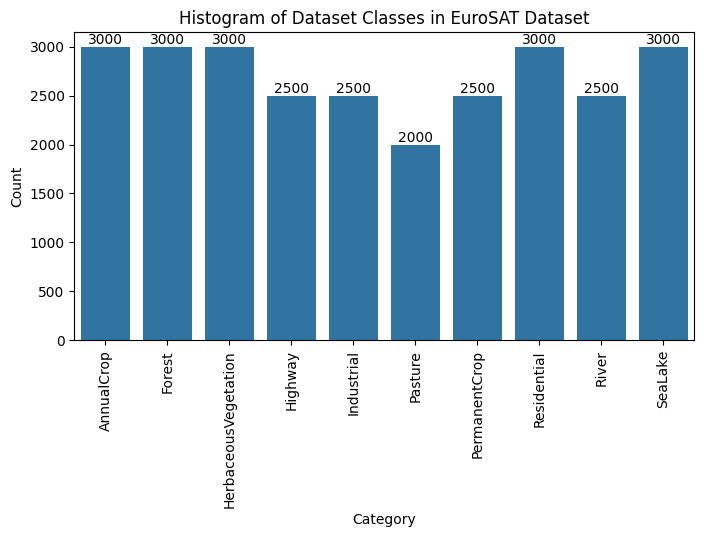

In [15]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(all_df, x="Category", y="Count")

#hist.set_xticks(range(len(all_df['Category'])))
#distribution_plot.set_xticklabels(all_df['Category'], rotation=90)
ax.set_title('Histogram of Dataset Classes in EuroSAT Dataset')
ax.bar_label(ax.containers[0], fontsize=10);
plt.xticks(rotation=90)
plt.show()

They all have pretty much the same distribution across classes

# Display sample of images

In [16]:
# https://keras.io/examples/vision/image_classification_from_scratch/

# plot to show a sample of images
def plot_images(data):
    class_names = data.class_names # gets class names using keras dataset, changed this so it worked with testing dataset where takedatset was created
    #class_names = class_names
    plt.figure(figsize=(6, 6))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            # uses label as index to get class names
            class_name = class_names[int(labels[i])]
            plt.title(class_name)
            plt.axis("off")
    plt.show()

Training Images


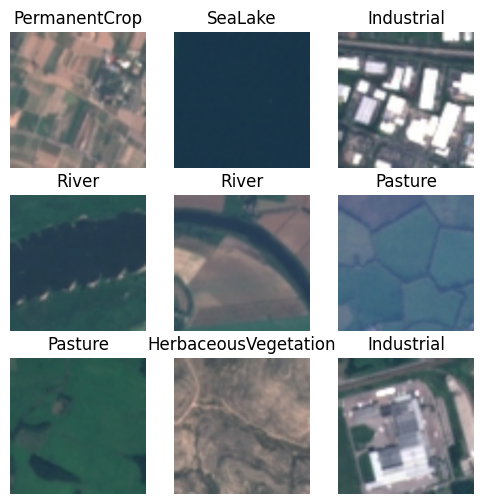

In [17]:
print('Training Images')
plot_images(train_ds) # plot for the training set